# Analyzing CIA Factbook Data - SQLite and Python
This project will focus on using SQLite along with python commands to hopefully get a little bit of insight on CIA Factbook Data

## Introduction
CIA World Factbook is a compendium of statistics about all of the countries on Earth, the Factbook has info such as population (2015), annual growth rate, and area (land and water) for countries. This information is stored in a database factbook.db on the factbook GitHub, which we can access. SQLite offers some GUI based tools that we can use much like pandas and matplotlib on their own. Each has their own advantages. First, we practice using SQL from jupyter.

## Reading In
Let's get some information about the tables.

In [49]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("factbook.db")
cursor = conn.cursor()
cursor.execute(query).fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'facts',
  'facts',
  47,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float)')]

In [5]:
query = "SELECT * FROM sqlite_master WHERE type = 'table';"
pd.read_sql_query(query, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [4]:
query2 = "SELECT * FROM facts LIMIT 5;"
pd.read_sql_query(query2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


## Getting More Information
Seeing the tables is great, but let's get some summary statistics too.

In [7]:
statistics = "SELECT MAX(population) as max_pop, MAX(population_growth) as max_growth, MIN(population) as min_pop, MIN(population_growth) as min_growth FROM facts;"
pd.read_sql_query(statistics, conn)

,max_pop,max_growth,min_pop,min_growth
0,7256490011,4.02,0,0.0


## Outliers
There can't be (or 99.9% unlikely) a country with a population of 0, or a country with a population over 7.2 billion, soooo let's take a look at these outliers.

In [8]:
min_pop_country = "SELECT * FROM facts WHERE population = (SELECT MIN(population) FROM facts);"
pd.read_sql_query(min_pop_country, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [9]:
max_pop_country = "SELECT * FROM facts WHERE population = (SELECT MAX(population) FROM facts);"
pd.read_sql_query(max_pop_country, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


Now it makes more sense, as the statistics included Antarctica and "the world" as countries, two things we would not normally include when making a list. Although they are "outliers" and not really useful when marking countries, it is a good idea to not remove them but to instead just take note that they exist.

## Histograms
Now let's use what we have, filtering out the outliers, and create some visualization.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cc5812b70>,
      dtype=object)

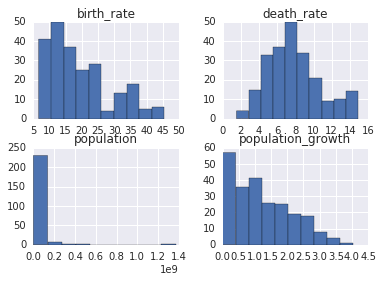

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
# ax = fig.add_subplot(221)

data = (
"SELECT population, population_growth, birth_rate, death_rate FROM facts WHERE population != (SELECT MAX(population) FROM facts) AND population != (SELECT MIN(population) FROM facts);"
)
pd.read_sql_query(data, conn).hist(ax=ax)
# Since the pd.read_sql_query method results in a df, we can automatically tack on the hist method at the end of it!

Some very quick observations:
* Birth rates seem to be lower than death rates (matches media concerns of today (2018))
* Populations have some outliers, but mostly fall in a goldilocks zone
* population growth can be relatively quick, but most of the time is a steady, gradual, or even stagnant, increase.

## Further Analysis
## Highest Population Density
Remember population density = ratio of population to land area

In [26]:
density = "SELECT name, (cast(population as float) / cast(area as float)) as density FROM facts ORDER BY density DESC LIMIT 20;"
pd.read_sql_query(density, conn)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


Interesting to see that biggest population != biggest population density. In fact, some of the smallest countries would have the highest densities due to such a small area that has to be accounted for. Hong Kong, what many people think of as a city, much less a country, is 4th on the list!

## Population Density Visualized

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cc5018908>]],
      dtype=object)

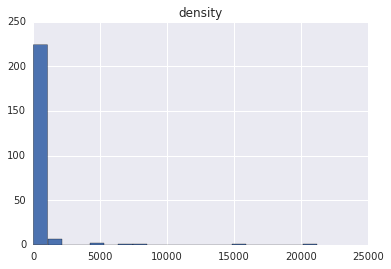

In [36]:
density_no_limit = "SELECT name, (cast(population as float) / cast(area as float)) as density FROM facts ORDER BY density DESC;"
pd.read_sql_query(density_no_limit, conn).hist(ax=ax, bins = 20)

The majority of countries fall into the first bin, which means a big land mass to house everyone most likely. This could also mean smaller area countries house smaller populations, so it looks like this is the norm. A few outliers are very big outliers though, as seen in the table. Overall, the world is not as "dense" as expected, at least within the view and scope of countries.

## Water to Land 

An interesting thing to explore within area would be water to land ratios. Although we think of countries as "land", perhaps we can find some countries that have their water 'land' outdo their land land.

In [35]:
water = "SELECT name, (cast(area_water as float) / cast(area_land as float)) as density FROM facts ORDER BY density DESC LIMIT 20;"
pd.read_sql_query(water, conn)

,name,density
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


Wow! Although for the most part land seems to dominate water, a 9 to 1 ratio or more after 15 countries, we see that some well-known countries actually have really high water to land ratios, including the Netherlands, Uganda, and, not surprisingly, countries like Puerto Rico (you could argue whether counting PR as a country is valid). However, the British Indian Ocean Territory and Virgin Islands (again, you could argue these "countries") take the cake as they not only have more water than land, the Virgin Islands' water outdo their land by 4 to 1, and the British Indian Ocean Territory a stunning 905 to 1! 

We can see the majority of countries fall within the "expected" range of ratio, as per the charts below:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cc4c19f98>]],
      dtype=object)

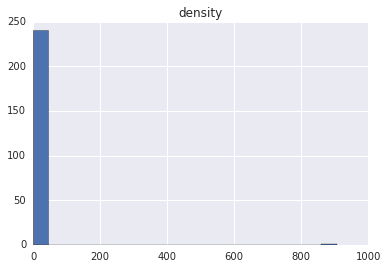

In [42]:
water_no_limit = "SELECT name, (cast(area_water as float) / cast(area_land as float)) as density FROM facts ORDER BY density DESC;"
pd.read_sql_query(water_no_limit, conn).hist(ax=ax, bins = 20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cc4bbab00>]],
      dtype=object)

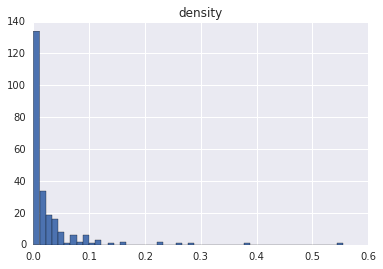

In [43]:
water_no_limit_adjusted = "SELECT name, (cast(area_water as float) / cast(area_land as float)) as density FROM facts WHERE name NOT IN ('British Indian Ocean Territory', 'Virgin Islands') ORDER BY density DESC;"
pd.read_sql_query(water_no_limit_adjusted, conn).hist(ax=ax, bins = 50)

We can see most countries don't even make it past the .1 ratio mark.

## Conclusion
For a relatively short project, we still got a lot of information regarding population densities, land ratios, birth rates, etc. We can now use techniques in here to work with larger datasets in the future, integrating SQLite with pandas when necessary to add to our arsenal of data science weapons.

Just a few lines of code can be very powerful, as demonstrated here with fitting the matplotlib hist method onto our SQLite analysis. Any questions such as finding which countries have more water than land could very well be easily found with 1 line of code. 

Also, remember when using SQLite and the likes to always close connections!

In [54]:
cursor.close()
conn.close()

ProgrammingError: Cannot operate on a closed database.